# Import dependencies
reference: https://towardsdatascience.com/exploring-normal-distribution-with-jupyter-notebook-3645ec2d83f8

In [2]:
import pandas
from pandas.io.json import json_normalize
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
from praveganb.pravega_stream import *
import grpc
import simplejson as json
import collections
from scipy.stats import norm
import numpy as np
import collections
import math
%matplotlib inline

# Define Pravega Parameters

In [3]:
gateway = '10.243.37.233:80'
scope = 'idracdemo'
stream = 'idracdata'

Initialize Connection

In [4]:
pravega_channel = grpc.insecure_channel(gateway)
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

View head and tail of stream

In [5]:
unindexed_stream = UnindexedStream(pravega_client, scope, stream)
stream_info = unindexed_stream.get_stream_info()
stream_info

head_stream_cut {
  text: "H4sIAAAAAAAAADOwykwpSkxOSc3N14ewEksSrUx0THWMrQx0gBBCAgCqKE54JwAAAA=="
  cut {
    key: 3
    value: 0
  }
  cut {
    key: 4
    value: 0
  }
  cut {
    key: 5
    value: 0
  }
}
tail_stream_cut {
  text: "H4sIAAAAAAAAACXGQQqAMAwEwA8F3JCk2+Q3xfbgQQTx/yjIXAZ1zHvsc53X9m88o1xCrCCfUlWCES1JUYR166lACqlw82bJF6ntHIxHAAAA"
  cut {
    key: 3
    value: 77104346397
  }
  cut {
    key: 4
    value: 111707556977
  }
  cut {
    key: 5
    value: 105383891009
  }
}

In [6]:
stream_size_MB = (list(stream_info.tail_stream_cut.cut.values())[0] - list(stream_info.head_stream_cut.cut.values())[0]) * 1e-6
stream_size_MB

111707.556977

In [7]:
# unindexed_stream.play_stream(from_stream_cut=None, to_stream_cut=None)

# Bell curve

## Normal distribution PDF with different standard deviations
Let’s plot probability distribution functions of a normal distribution where the mean has different standard deviations.
scipy.norm.pdf has keywords, loc and scale. The location (loc) keyword specifies the mean and the scale (scale) keyword specifies the standard deviation.

In [8]:
text = "H4sIAAAAAAAAACXGSQqAMAwAwA8FTJo9vwm2Bw8iiP9HQeYyWMe8e5/rvLZ//XQJKHAhfIqQPck0TAXSQtNVcgxwSjcJZMkXSM81EUYAAAA="
from_stream_cut = pravega.pb.StreamCut(text=text)
read_events = unindexed_stream.read_events_from_stream(from_stream_cut, None)
count = 0
reports = []
for i, event in enumerate(read_events):
    metric_report = dict(event)
    if metric_report.get('MetricValues') and metric_report.get('Id') == 'ThermalSensor':
        _report = dict()
        sum = 0
        for metric in metric_report.get('MetricValues'):
            try:
                sum += float(metric['MetricValue'])
            except:
                pass
        _report['Timestamp'] = metric_report['Timestamp']
        _report['RemoteAddr'] = metric_report['RemoteAddr']
        _report['Id'] = metric_report['Id']
        _report['avg'] = sum/int(metric_report['MetricValues@odata.count'])
        reports.append(_report)
        count += 1
    if count >= 1000:
        break
display(pandas.DataFrame.from_dict(reports, orient='columns'))
    

,Timestamp,RemoteAddr,Id,avg
0,2020-03-19T13:51:18.334Z,10.243.19.72,ThermalSensor,27.000000
1,2020-03-19T13:51:22.990Z,10.243.19.141,ThermalSensor,24.958333
2,2020-03-19T13:51:43.130Z,10.243.19.76,ThermalSensor,26.000000
3,2020-03-19T13:51:47.274Z,10.243.19.158,ThermalSensor,29.000000
4,2020-03-19T13:51:48.581Z,10.243.19.151,ThermalSensor,23.500000
...,...,...,...,...
995,2020-03-19T14:11:59.963Z,10.243.19.201,ThermalSensor,33.083333
996,2020-03-19T14:27:08.509Z,10.243.19.72,ThermalSensor,27.000000
997,2020-03-19T14:11:44.571Z,10.243.19.144,ThermalSensor,24.500000
998,2020-03-19T14:12:07.145Z,10.243.19.159,ThermalSensor,28.500000


# Calculate std, avg

In [9]:

s1 = 0
s2 = 0
count = 0
mean = 0
for report in reports:
    s1 += report['avg']
    s2 += pow(report['avg'], 2)
    count += 1
# calculate mean
mean = s1/count
# (sqrt(count*.s2 - pow(s1, 2)))/count
std = (math.sqrt(count*s2 - pow(s1, 2)))/count
std, mean, count

(3.496404820957873, 28.493944233462614, 1000)

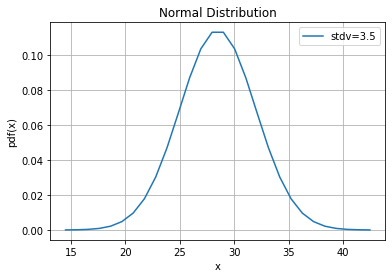

In [10]:
fig, ax = plt.subplots()
x = np.linspace(mean-4*std,mean+4*std, int(mean))
ax.plot(x, norm.pdf(x, scale=std, loc=mean), label='stdv=%.1f' % std)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title('Normal Distribution')
ax.legend(loc='best', frameon=True)
#ax.set_ylim(0,0.45)
ax.grid(True)

# Using random normal distribution values
norm.rvs generates random normal distribution numbers according to the scale which is the standard deviation, the loc which is the mean and the size. We create a histogram for the generated numbers and add the PDF.

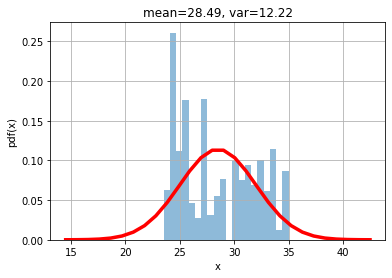

In [11]:
fig, ax = plt.subplots()
xs = [i['avg'] for i in reports ]
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
v = np.var(xs)
m = np.mean(xs)
# ax = fig.add_subplot(111)
ax.hist(xs, bins=20, alpha=0.5, density=True)
ax.plot(x, p, 'r-', lw=std)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title(f'mean={m:.2f}, var={v:.2f}')
ax.grid(True)


# Cumulative normal distribution function
The cumulative distribution function of a random variable X, evaluated at x, is the probability that X will take a value less than or equal to x. Since the normal distribution is a continuous distribution, the shaded area of the curve represents the probability that X is less or equal than x.

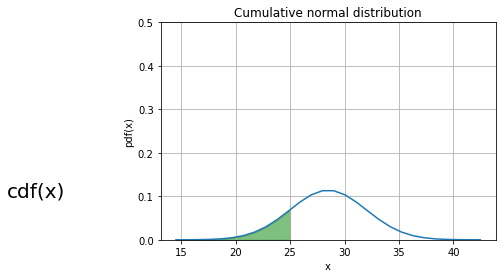

In [12]:
# random variable (temperature)
randtemp = 25
fig, ax = plt.subplots()
# for distribution curve
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("Cumulative normal distribution")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
# for fill_between
px=np.arange(mean-4*std,randtemp, 0.01)
ax.set_ylim(0,0.5)
ax.fill_between(px,norm.pdf(px, scale=std, loc=mean),alpha=0.5, color='g')
# for text
ax.text(-1,0.1,"cdf(x)", fontsize=20)
plt.show()

# Calculating probability of normal distribution
Given the mean and the standard deviation, we can find the probability of 𝑃(𝑋<30).

In norm.cdf, the location (loc) keyword specifies the mean and the scale (scale) keyword specifies the standard deviation.

In [13]:
from scipy.stats import norm
lessthan30=norm.cdf(x=30, loc=mean, scale=std)
print(lessthan30)

0.6666727773214102


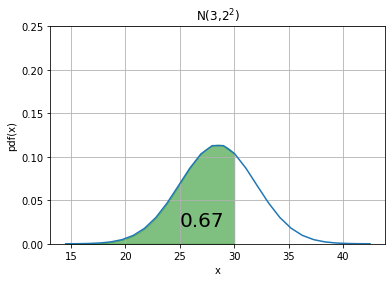

In [14]:
fig, ax = plt.subplots()
# for distribution curve
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("N(3,$2^2$)")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
# for fill_between
px=np.arange(mean-4*std, 30, 0.01)
ax.set_ylim(0,0.25)
ax.fill_between(px,norm.pdf(px,scale=std, loc=mean),alpha=0.5, color='g')
# for text
ax.text(25,0.02,round(lessthan30,2), fontsize=20)
plt.show()

# Interval between variables
To find the probability of an interval between certain variables, you need to subtract cdf from another cdf. Let's find 𝑃(28<𝑋<30) with a meanand a standard deviation.


In [15]:
norm(mean, std).cdf(30) - norm(mean,std).cdf(28)

0.22284525793184273

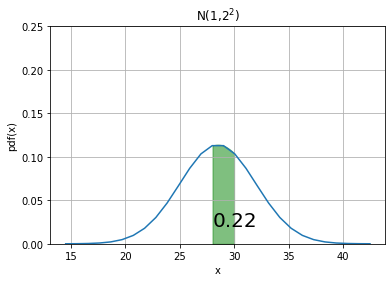

In [16]:
fig, ax = plt.subplots()
# for distribution curve
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("N(1,$2^2$)")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
px=np.arange(28, 30, 0.01)
ax.set_ylim(0,0.25)
ax.fill_between(px,norm.pdf(px,scale=std, loc=mean),alpha=0.5, color='g')
pro=norm(mean, std).cdf(30) - norm(mean,std).cdf(28)
ax.text(28,0.02,round(pro,2), fontsize=20)
plt.show()

## To find the probability of 𝑃(𝑋>35), we can use sf which is called the survival function and it returns 1-cdf.


In [17]:
gr35sf=norm.sf(x=35, loc=mean, scale=std)
gr35sf

0.03138731024391461

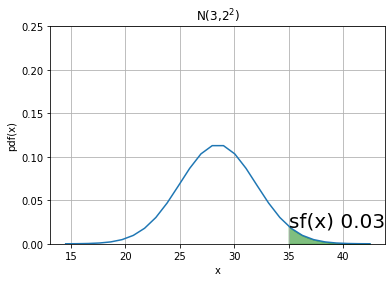

In [18]:
fig, ax = plt.subplots()
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("N(3,$2^2$)")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
px=np.arange(35, mean+4*std, 0.01)
ax.set_ylim(0,0.25)
ax.fill_between(px,norm.pdf(px,scale=std, loc=mean),alpha=0.5, color='g')
ax.text(35,0.02,"sf(x) %.2f" %(gr35sf), fontsize=20)
plt.show()

# The above graph is the same as 1−𝑃(𝑋<4).

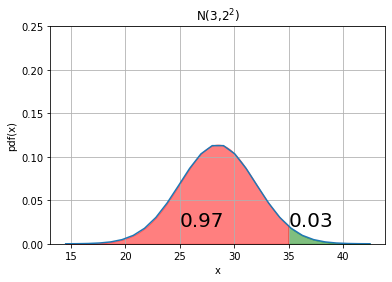

In [19]:
gr35sf=norm.sf(x=35, loc=mean, scale=std)
gr=1-gr35sf
fig, ax = plt.subplots()
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("N(3,$2^2$)")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
px=np.arange(35, mean+4*std, 0.01)
ax.set_ylim(0,0.25)
ax.fill_between(px,norm.pdf(px,scale=std, loc=mean),alpha=0.5, color='g')
px1=np.arange(mean-4*std, 35, 0.01)
ax.fill_between(px1,norm.pdf(px1,scale=std, loc=mean),alpha=0.5, color='r')
ax.text(25,0.02,round(gr,2), fontsize=20)
ax.text(35, 0.02,round(gr35sf,2), fontsize=20)
plt.show()

# Finding quantiles
𝑘 in 𝑃(𝑋≤𝑘)=0.95
is known as quantile, in this case the 95% quantile.
Percent point function
ppf is the inverse of cdf and it is called Percent point function. Given the mean and the standard deviation, we can find the quantile a in 𝑃(𝑋<𝑎)=0.506 by using ppf.


In [20]:
norm.ppf(q=0.506, loc=mean, scale=std)

28.546531339134624

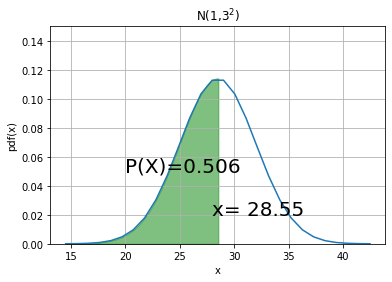

In [21]:
fig, ax = plt.subplots()
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("N(1,$3^2$)")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
xpoint=norm.ppf(q=0.506, loc=mean, scale=std)
px=np.arange(mean-4*std,xpoint,0.01)
ax.set_ylim(0,0.15)
ax.fill_between(px,norm.pdf(px,loc=mean,scale=std),alpha=0.5, color='g')
ax.text(28,0.02,"x= %.2f" %xpoint, fontsize=20)
ax.text(20,0.05,"P(X)=0.506", fontsize=20)
plt.show()

# Inverse survival function
With the same mean and standard deviation, we can find the quantile b in 𝑃(𝑋>𝑏)=0.198 using the inverse survival function isf. This is the same as using ppf with 𝑞=(1−0.198).

In [22]:
norm.isf(q=0.198, loc=mean, scale=std)

31.461646094064058

# Interval around the mean
norm.interval returns endpoints of the range that contains alpha percent of the distribution. For example, with a mean and a standard deviation to find 95% of the probability, norm.interval returns x values around the mean, in this case, 𝜇=0.

In [23]:
a,b = norm.interval(alpha=0.95, loc=mean, scale=std)
print(a,b)

21.641116709012966 35.34677175791226


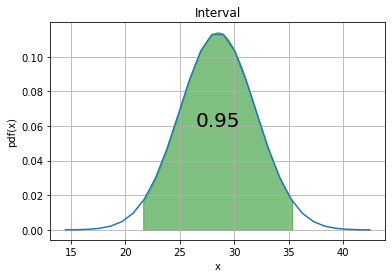

In [24]:
fig, ax = plt.subplots()
x = np.linspace(mean-4*std,mean+4*std, int(mean))
p = norm.pdf(x, scale=std, loc=mean)
ax.plot(x, p)
ax.set_title("Interval")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
px=np.arange(a,b,0.01)
#ax.set_ylim(0,0.5)
ax.fill_between(px,norm.pdf(px,loc=mean,scale=std),alpha=0.5, color='g')
ax.text(mean-2,0.06,"0.95", fontsize=20)
plt.show()

# Run live data plot

In [25]:
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

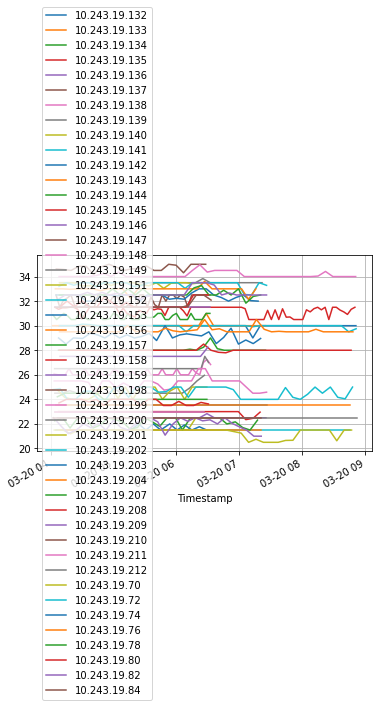

In [ ]:
#data = collections.defaultdict(list)
dfs= pandas.DataFrame()
text = "H4sIAAAAAAAAACXGQQqAMAwEwA8F3LSbJs1viu3Bgwji/1GQuQzymPfY5zqv7d94RlJMakI+qfBONXUGRAGyklqC4mSzsNK1vff1VbtHAAAA"
# text = "H4sIAAAAAAAAACXGSQqAMAwAwA8FTJo9vwm2Bw8iiP9HQeYyWMe8e5/rvLZ//XQJKHAhfIqQPck0TAXSQtNVcgxwSjcJZMkXSM81EUYAAAA="
from_stream_cut = pravega.pb.StreamCut(text=text)
read_events = unindexed_stream.read_events_from_stream(from_stream_cut, None)
count = 0
for i, event in enumerate(read_events):
    metric_report = dict(event)
    clear_output(wait=True)
    if metric_report.get('MetricValues') and metric_report.get('Id') == 'ThermalSensor':
        _report = dict()
        _report['RemoteAddr'] = metric_report['RemoteAddr']
        _report['Timestamp'] = metric_report['Timestamp']
        sum = 0
        c= 0
        for metric in metric_report.get('MetricValues'):
            try:
                sum += float(metric['MetricValue'])
                c +=1
            except:
                pass
        _report['avg'] = sum/c
        df = pandas.DataFrame(_report, index=[1])
        df['Timestamp'] = pandas.to_datetime(df['Timestamp'],
                                   format="%Y-%m-%dT%H:%M:%S.%fZ")
        df.set_index('Timestamp', inplace=True)
        if count == 0:
            dfs = df 
        else:
            #display(count)
            dfs = dfs.append(df)
        
        # display(dfs)
        count += 1
        dfs.groupby('RemoteAddr')['avg'].plot()
        plt.grid(True)
        plt.legend(loc='center left') 
        plt.show()
        # data[_report['RemoteAddr']].append(_report['avg'])
        # live_plot(data)